In [1]:
from sklearn.datasets import make_friedman1
import numpy as np
import statistics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from tabulate import tabulate

from package import gpr
from package import io
from package import rf
from package import testhelper as th

In [2]:
# define training data size
training_num = 2000

# x-values: all uniformly distributed between 0 and 0.5
x0_train=np.random.rand(training_num)*0.5
x1_train=np.random.rand(training_num)*0.5
x2_train=np.random.rand(training_num)*0.5
x3_train=np.random.rand(training_num)*0.5
x4_train=np.random.rand(training_num)*0.5
X_train = [[x0_train[i], x1_train[i], x2_train[i], x3_train[i], x4_train[i]] for i in range(0,training_num)]

# y-value with friedman function
y_train = 10*np.sin(np.pi*x0_train*x1_train) + 20*(x2_train - 0.5)**2 + 10*x3_train + 5*x4_train
y_train = y_train.tolist()

In [3]:
# Train GPR
GPR = gpr.GPR()
GPR.train_synth(X_train, y_train, std=2.756)

# Train RF
RF = rf.RF()
RF.train_synth(X_train, y_train, std=2.756)

/Users/glennpalmer/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [23]:
# define test data size
test_num = 1000

# x-values: add or remove the *0.5 for each one
x0_test=np.random.rand(test_num)*0.5
x1_test=np.random.rand(test_num)*0.5
x2_test=np.random.rand(test_num)*0.5
x3_test=np.random.rand(test_num)*5
x4_test=np.random.rand(test_num)*0.5
X_test = [[x0_test[i], x1_test[i], x2_test[i], x3_test[i], x4_test[i]] for i in range(0,test_num)]

# y-value with friedman function
y_test = 10*np.sin(np.pi*x0_test*x1_test) + 20*(x2_test - 0.5)**2 + 10*x3_test + 5*x4_test

In [24]:
def test2(test_data):
    # Define GPR and RF errors
    GPR_pred, GPR_errors = GPR.predict(test_data, True)
    RF_pred, RF_errors = RF.predict(test_data, True)
    RF_errors = 0.33 * RF_errors
    GPR_res = abs(GPR_pred-y_test)/2.756
    RF_res = abs(RF_pred-y_test)/2.756
    predictions = [th.predictdomain(GPR_errors[i], RF_errors[i]) for i in range(0, len(test_data))]
    results = [(predictions[i], GPR_errors[i], GPR_res[i], RF_errors[i], RF_res[i], x0_test[i], x1_test[i], x2_test[i], x3_test[i], x4_test[i]) for i in range(0, len(test_data))]
    results_print = [(predictions[i], GPR_errors[i], RF_errors[i], x2_test[i]) for i in range(0, len(test_data))]
    #print(tabulate(results_print, headers=["In domain?", "GPR predicted error", "0.33*RF predicted error", "x2_test value"]))
    return results

In [25]:
results = test2(X_test)

/Users/glennpalmer/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


# Letting x_k run from 0 to 5:

In [31]:
k = 3

in_domain = []
out_domain = []
for i in range(0,test_num):
    if results[i][0]==0:
        out_domain.append(results[i][5+k])
    else:
        in_domain.append(results[i][5+k])

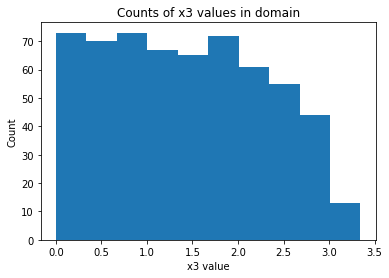

In [32]:
plt.xlabel("x" + str(k) + " value")
plt.ylabel("Count")
plt.title("Counts of x" + str(k) + " values in domain")
plt.hist(in_domain);

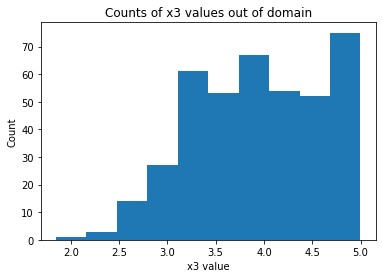

In [33]:
plt.xlabel("x" + str(k) + " value")
plt.ylabel("Count")
plt.title("Counts of x" + str(k) + " values out of domain")
plt.hist(out_domain);

In [34]:
bins = np.linspace(0, 5, 50, endpoint=False)
digitized_in = np.digitize(in_domain, bins)
digitized_out = np.digitize(out_domain, bins)

In [35]:
digitized_in = digitized_in.tolist()
digitized_out = digitized_out.tolist()

frac = []
for i in range(1,51):
    frac_in = (digitized_in.count(i)*1.0/(digitized_in.count(i)+digitized_out.count(i)))
    frac.append(frac_in)

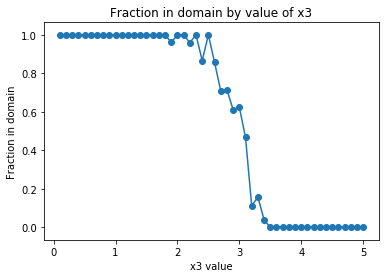

In [36]:
x = np.linspace(0.1,5,50)
y = frac

plt.xlabel("x" + str(k) + " value")
plt.ylabel("Fraction in domain")
plt.title("Fraction in domain by value of x" + str(k))

plt.scatter(x,y);
plt.plot(x,y);